In [1]:
# 시작하기: 퍼사드 임포트
from qdl.facade import QDL
import pandas as pd
import numpy as np

In [2]:
q = QDL()
# 특성(Chars) 데이터셋 (와이드): 초과수익률 
wide_market_equity = q.load_char(
    country="usa",
    vintage="2020-",
    char="market_equity",
    date_col="eom",
)

In [33]:
print(wide_market_equity.head(10))

            10026.0      10028.0      10032.0      10044.0      10051.0      \
eom                                                                           
2020-01-31  3137.526891    58.425082  2078.268720    49.919998   912.167351   
2020-02-29  3042.553719    71.617842  1947.704205    46.457899   861.387649   
2020-03-31  2285.448000    67.848479  1601.608840    29.112001   583.143817   
2020-04-30  2399.342617    98.272603  1829.670300    27.595751   693.677543   
2020-05-31  2429.563532    96.657158  1874.324956    26.001690   693.879503   
2020-06-30  2401.231388   164.236397  2059.364089    25.776250   625.852060   
2020-07-31  2326.541298   113.888521  2170.308087    20.172320   659.865745   
2020-08-31  2568.775192   104.465123  2224.743211    19.778420   752.875769   
2020-09-30  2466.326838   115.503959  2065.644900    16.259560   602.757808   
2020-10-31  2564.306689   108.772959  2016.799107    16.270280   665.624444   

            10066.0        10104.0       10107.0   

In [4]:
# 특성(Chars) 데이터셋 (와이드): size_grp
wide_size_grp = q.load_char(
    country="usa",
    vintage="2020-",
    char="size_grp",
)

In [5]:
print(wide_size_grp.head(10))

           10026.0     10028.0     10032.0     10044.0     10051.0      \
eom                                                                      
2020-01-31       large       micro       small       micro       small   
2020-02-29       large       micro       small       micro       small   
2020-03-31       large       micro       small       micro       small   
2020-04-30       large       micro       small       micro       small   
2020-05-31       large       micro       small       micro       small   
2020-06-30       large       micro       small        nano       small   
2020-07-31       small       micro       small        nano       small   
2020-08-31       large       micro       small        nano       small   
2020-09-30       large       micro       small        nano       small   
2020-10-31       large       micro       small        nano       small   

           10066.0     10104.0     10107.0     10138.0     10145.0      ...  \
eom                             

In [6]:
# micro가 아닌 셀을 True로 하는 마스크 생성
non_micro_mask = wide_size_grp != "micro"

# wide_market_equity에 마스크 적용 (micro인 부분은 NaN 처리됨)
wide_market_equity_non_micro = wide_market_equity.where(non_micro_mask)

# 이제 여기서 rank를 계산
wide_market_equity_xs_rank = wide_market_equity_non_micro.rank(axis=1, method='min', pct=True)

print(wide_market_equity_xs_rank.head(10))
print(wide_market_equity_xs_rank.shape)

            10026.0      10028.0      10032.0      10044.0      10051.0      \
eom                                                                           
2020-01-31     0.606498          NaN     0.508303          NaN     0.312635   
2020-02-29     0.610026          NaN     0.503502          NaN     0.311095   
2020-03-31     0.611973          NaN     0.533357          NaN     0.311937   
2020-04-30     0.589949          NaN     0.524763          NaN     0.306264   
2020-05-31     0.578357          NaN     0.521896          NaN     0.294245   
2020-06-30     0.560059          NaN     0.523950     0.128224     0.240236   
2020-07-31     0.531426          NaN     0.514114     0.096349     0.234851   
2020-08-31     0.552661          NaN     0.516330     0.097248     0.267156   
2020-09-30     0.556912          NaN     0.516338     0.071095     0.230521   
2020-10-31     0.565542          NaN     0.505861     0.069627     0.252220   

            10066.0      10104.0      10107.0      

In [7]:
wide_market_equity_xs_high_mask = wide_market_equity_xs_rank >= 0.666
wide_market_equity_xs_low_mask = wide_market_equity_xs_rank <= 0.333
print(wide_market_equity_xs_high_mask.head(5))

            10026.0      10028.0      10032.0      10044.0      10051.0      \
eom                                                                           
2020-01-31        False        False        False        False        False   
2020-02-29        False        False        False        False        False   
2020-03-31        False        False        False        False        False   
2020-04-30        False        False        False        False        False   
2020-05-31        False        False        False        False        False   

            10066.0      10104.0      10107.0      10138.0      10145.0      \
eom                                                                           
2020-01-31        False         True         True         True         True   
2020-02-29        False         True         True         True         True   
2020-03-31        False         True         True         True         True   
2020-04-30        False         True         True  

In [8]:
# 포트폴리오 분류
non_micro_top_portfolio = wide_market_equity_xs_rank.where(wide_market_equity_xs_high_mask)
non_micro_bottom_portfolio = wide_market_equity_xs_rank.where(wide_market_equity_xs_low_mask)
non_micro_middle_portfolio = wide_market_equity_xs_rank.where(~wide_market_equity_xs_high_mask & ~wide_market_equity_xs_low_mask)

In [9]:
# 1. non-micro만 이용해서 분위수 cutoff 구하기
q_low  = wide_market_equity_non_micro.quantile(0.333, axis=1)
q_high = wide_market_equity_non_micro.quantile(0.666, axis=1)

# 2. micro 종목만 추출
micro_mask = (wide_size_grp == "micro")
wide_market_equity_micro = wide_market_equity.where(micro_mask)

# 3. micro 종목을 cutoff 기준으로 분류
micro_top_portfolio    = wide_market_equity_micro.where(wide_market_equity_micro.ge(q_high, axis=0))
micro_bottom_portfolio = wide_market_equity_micro.where(wide_market_equity_micro.le(q_low, axis=0))
micro_middle_portfolio = wide_market_equity_micro.where(
    (wide_market_equity_micro.gt(q_low, axis=0)) & 
    (wide_market_equity_micro.lt(q_high, axis=0))
)

# 4. 기존 포트폴리오와 micro 분류 결과 합치기
top_portfolio_market_equity    = non_micro_top_portfolio.combine_first(micro_top_portfolio)
middle_portfolio_market_equity = non_micro_middle_portfolio.combine_first(micro_middle_portfolio)
bottom_portfolio_market_equity = non_micro_bottom_portfolio.combine_first(micro_bottom_portfolio)
print(top_portfolio_market_equity.head(10))

            10026.0      10028.0      10032.0      10044.0      10051.0      \
eom                                                                           
2020-01-31          NaN          NaN          NaN          NaN          NaN   
2020-02-29          NaN          NaN          NaN          NaN          NaN   
2020-03-31          NaN          NaN          NaN          NaN          NaN   
2020-04-30          NaN          NaN          NaN          NaN          NaN   
2020-05-31          NaN          NaN          NaN          NaN          NaN   
2020-06-30          NaN          NaN          NaN          NaN          NaN   
2020-07-31          NaN          NaN          NaN          NaN          NaN   
2020-08-31          NaN          NaN          NaN          NaN          NaN   
2020-09-30          NaN          NaN          NaN          NaN          NaN   
2020-10-31          NaN          NaN          NaN          NaN          NaN   

            10066.0      10104.0      10107.0      

In [10]:
# 날짜별로 포트폴리오에 포함된 주식 수 카운트
top_count    = top_portfolio_market_equity.notna().sum(axis=1)
middle_count = middle_portfolio_market_equity.notna().sum(axis=1)
bottom_count = bottom_portfolio_market_equity.notna().sum(axis=1)

# 5개 미만인지 확인 (True/False)
top_few    = top_count < 5
middle_few = middle_count < 5
bottom_few = bottom_count < 5

# 하나라도 True가 있는지 확인
any_less_than_5 = (
    (top_count < 5) |
    (middle_count < 5) |
    (bottom_count < 5)
).any()

print("포트폴리오 중 하나라도 5개 미만인 날이 있었는지?", any_less_than_5)



포트폴리오 중 하나라도 5개 미만인 날이 있었는지? False


In [11]:
top_mask_market_equity    = top_portfolio_market_equity.notna()
middle_mask_market_equity = middle_portfolio_market_equity.notna()
bottom_mask_market_equity  = bottom_portfolio_market_equity.notna()

In [12]:
# 특성(Chars) 데이터셋 (와이드): 초과수익률 
wide_ret_exc = q.load_char(
    country="usa",
    vintage="2020-",
    char="ret_exc",
    date_col="eom",
)

In [13]:
# shift(1) 하는 이유: forward looking 하지 않기 위해. 
short_port = -1 * wide_ret_exc[top_mask_market_equity.shift(1)] 
long_port  = wide_ret_exc[bottom_mask_market_equity.shift(1)] 

In [25]:
short_port_returns_ew = short_port.mean(axis=1)
long_port_returns_ew = long_port.mean(axis=1)
size_factor_returns_ew = short_port_returns_ew + long_port_returns_ew
print(size_factor_returns_ew.head())

eom
2020-01-31         NaN
2020-02-29    0.018360
2020-03-31   -0.046164
2020-04-30    0.070133
2020-05-31    0.008932
dtype: float64


<Axes: xlabel='eom'>

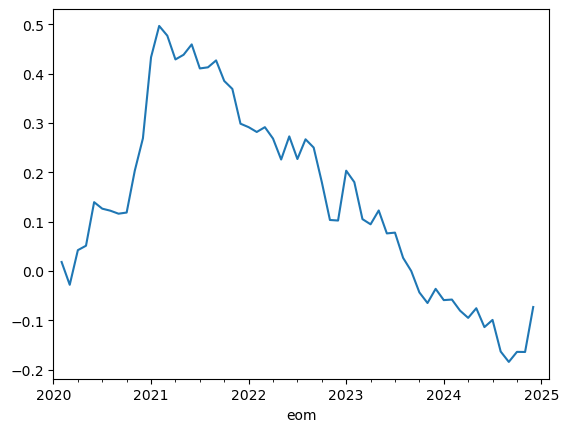

In [16]:
size_factor_returns_ew.cumsum().plot()

<Axes: xlabel='date'>

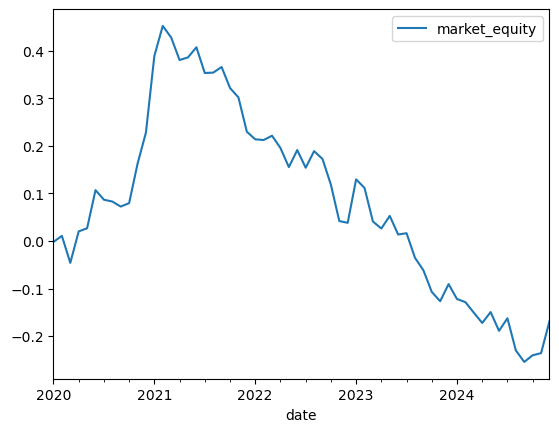

In [29]:
size_factor_ew_answer =q.load_factors(
    country="usa",
    dataset='factor',
    weighting='ew',
    factors=["market_equity"],
)

size_factor_ew_answer.loc['2020-01-31':, :].cumsum().plot()

In [18]:
my_factor = pd.DataFrame(size_factor_returns_ew)
my_factor.columns = ['market_equity']

In [26]:
# === 1. 포트폴리오 마스크 (Top / Bottom) ===
# mask도 반드시 shift(1) 적용 → t-1 정보 기준으로 포트폴리오 결정


# === 2. VW 가중치 계산 함수 ===
def get_portfolio_vw_weights(me_df, mask_shifted):
    """
    me_df         : wide_market_equity (전체 주식 ME)
    mask_shifted  : t-1 시점 포트폴리오 마스크
    """
    port_me = me_df.where(mask_shifted)                       # 포트 ME만 남김
    return port_me.div(port_me.sum(axis=1), axis=0)           # Σ포트 ME로 나눠서 정규화

# === 3. 포트폴리오별 VW 가중치 (t-1 기준) ===
top_weights    = get_portfolio_vw_weights(wide_market_equity.shift(1), top_portfolio_market_equity.notna().shift(1))
middle_weights = get_portfolio_vw_weights(wide_market_equity.shift(1), middle_portfolio_market_equity.notna().shift(1))
bottom_weights = get_portfolio_vw_weights(wide_market_equity.shift(1), bottom_portfolio_market_equity.notna().shift(1))

# === 4. 포트폴리오별 VW 수익률 (t 시점 ret_exc) ===
def get_portfolio_vw_return(ret_df, weights):
    return (ret_df * weights).sum(axis=1)   # 종목별 ret × weight 합

top_ret_vw    = get_portfolio_vw_return(wide_ret_exc, top_weights)
middle_ret_vw = get_portfolio_vw_return(wide_ret_exc, middle_weights)
bottom_ret_vw = get_portfolio_vw_return(wide_ret_exc, bottom_weights)

# === 5. 팩터 수익률 (예: SMB = Small – Big)
size_factor_returns_vw = bottom_ret_vw - top_ret_vw

<Axes: xlabel='eom'>

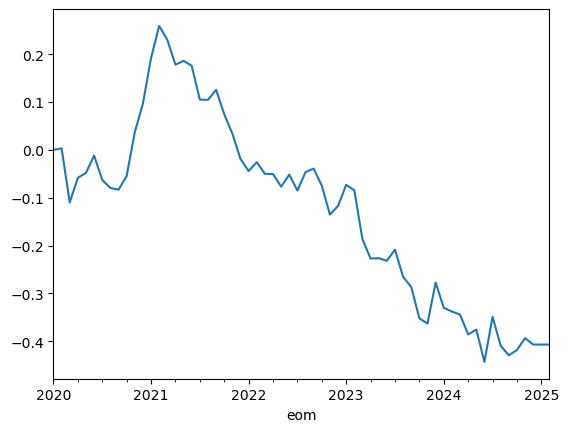

In [27]:
size_factor_returns_vw.cumsum().plot()

<Axes: xlabel='date'>

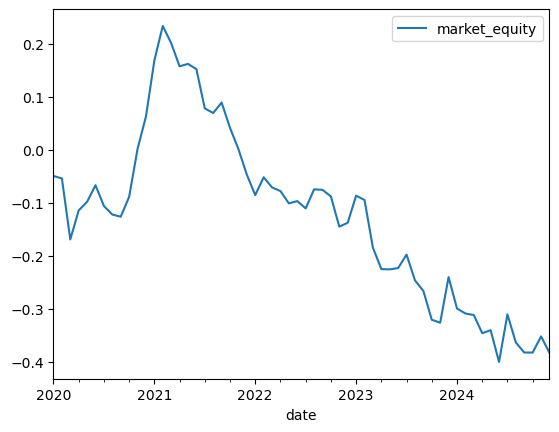

In [34]:
size_factor_ew_answer =q.load_factors(
    country="usa",
    dataset='factor',
    weighting='vw',
    factors=["market_equity"],
)

size_factor_ew_answer.loc['2020-01-31':, :].cumsum().plot()

In [43]:
my_factor = pd.DataFrame(size_factor_returns_vw)
my_factor.columns = ['market_equity']

In [38]:
# === 1. 포트폴리오 마스크 (Top / Bottom / Middle) ===
# 반드시 shift(1) → t-1 시점 정보 기준

# === 2. Capped VW 가중치 계산 함수 (clip + normalize) ===
def get_vw_cap_weights(me_df, mask_shifted, cap=0.8):
    """
    me_df        : wide_market_equity (전체 종목 ME, t-1 기준)
    mask_shifted : t-1 시점 포트폴리오 마스크
    cap          : 개별 weight 상한 (기본=0.8)
    """
    # 포트 ME만 추출
    port_me = me_df.where(mask_shifted)
    
    # 기본 VW weight (포트 내부 합 = 1)
    weights = port_me.div(port_me.sum(axis=1), axis=0)
    
    # cap 적용 후 normalize
    capped = weights.clip(upper=cap)
    capped_norm = capped.div(capped.sum(axis=1), axis=0)  # 합 다시 1
    
    return capped_norm

# === 3. 포트폴리오별 VW capped weight (t-1 기준 ME 사용) ===
top_weights_cap    = get_vw_cap_weights(wide_market_equity.shift(1), top_portfolio_market_equity.notna().shift(1))
middle_weights_cap = get_vw_cap_weights(wide_market_equity.shift(1), middle_portfolio_market_equity.notna().shift(1))
bottom_weights_cap = get_vw_cap_weights(wide_market_equity.shift(1), bottom_portfolio_market_equity.notna().shift(1))

# === 4. 포트폴리오 수익률 계산 (t 시점 ret_exc 사용) ===
def get_portfolio_return(ret_df, weights):
    return (ret_df * weights).sum(axis=1)

top_ret_vw_cap    = get_portfolio_return(wide_ret_exc, top_weights_cap)
middle_ret_vw_cap = get_portfolio_return(wide_ret_exc, middle_weights_cap)
bottom_ret_vw_cap = get_portfolio_return(wide_ret_exc, bottom_weights_cap)

# === 5. 팩터 수익률 예시 (Small - Big) ===
size_factor_returns_vw_cap = bottom_ret_vw_cap - top_ret_vw_cap


<Axes: xlabel='eom'>

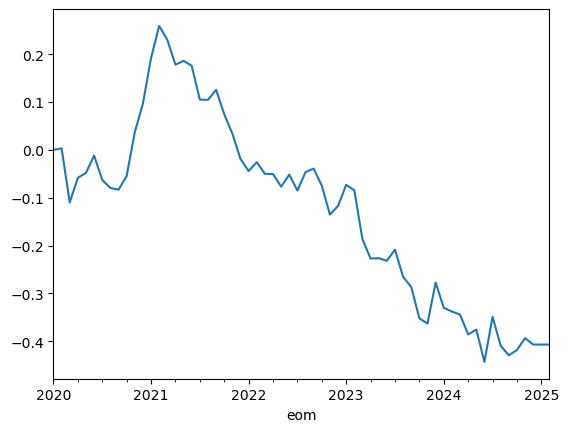

In [39]:
size_factor_returns_vw_cap.cumsum().plot()

<Axes: xlabel='date'>

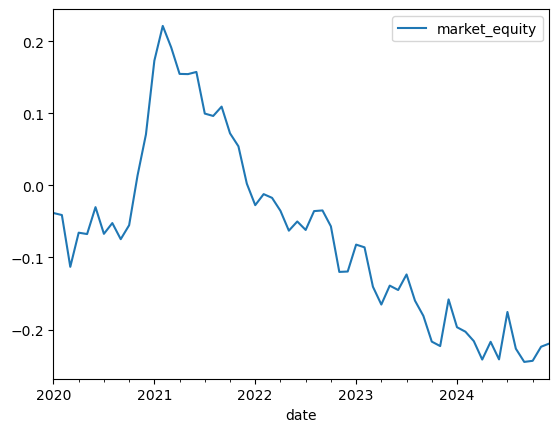

In [40]:
size_factor_ew_answer =q.load_factors(
    country="usa",
    dataset='factor',
    weighting='vw_cap',
    factors=["market_equity"],
)

size_factor_ew_answer.loc['2020-01-31':, :].cumsum().plot()

In [42]:
my_factor = pd.DataFrame(size_factor_returns_vw_cap)
my_factor.columns = ['market_equity']